# **Практическая работа №7. Использование автоэнкодера для решения задач семантической сегментации. Часть 1**

# Этап 1. Выбор и обработка исходных данных. Разделение на обучающую и тестовую выборку

# Разделение данных по папкам на обучающую и проверочную выборку (после разделения снимка и маски на патчи)


Ниже представлен Код для разделения папки на train и val.
После создания новых папок переименуйте их и расположите в формате, приведенном ниже, для использования для семантической сегментации с помощью генераторов данных. 

[Документация](https://pypi.org/project/split-folders/) 

### Подсказка

In [88]:
!pip install split-folders
!pip install patchify
!pip install segmentation-models

In [1]:
import cv2
import os
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from keras.metrics import MeanIoU
import tensorflow as tf
sm.set_framework('tf.keras')
from tensorflow.python.client import device_lib

import tensorflow
tensorflow.compat.v1.enable_eager_execution()

import pandas as pd

import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "png"

print(f'Tensorflow version: {tensorflow.__version__}')
print(f'Segmentaion models framework: {sm.framework()}')
print(f'Local machine devices: {device_lib.list_local_devices()}')

C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Segmentation Models: using `keras` framework.
Tensorflow version: 2.10.0
Segmentaion models framework: tf.keras
Local machine devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1625841207213038072
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5364940800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4555548232178026743
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:02:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
root_directory = 'Semantic segmentation dataset/'
patch_size = 256

In [3]:
image_dataset = []  

images_path = root_directory+ "Image/"
Path(images_path).mkdir(parents=True, exist_ok=True)

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   
                image = cv2.imread(path+"/"+image_name, 1)  
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size  
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
                image = np.array(image)             
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = single_patch_img[0] 
                        
                        new_img_path = images_path + image_name + "_patch_" + str(i) + str(j) + ".jpg"
                        #print(f'Writing image at path: {new_img_path}')
                        cv2.imwrite(new_img_path, single_patch_img)

In [4]:
image_dataset = []  

images_path = root_directory+ "Mask/"
Path(images_path).mkdir(parents=True, exist_ok=True)

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".png"):   
                image = cv2.imread(path+"/"+image_name, 1)  
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size  
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  
                image = np.array(image)             
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = single_patch_img[0] 
                        
                        new_img_path = images_path + image_name + "_patch_" + str(i) + str(j) + ".png"
                        #print(f'Writing image at path: {new_img_path}')
                        cv2.imwrite(new_img_path, single_patch_img)

In [5]:
import splitfolders  # or import split_folders

input_folder = 'Semantic segmentation dataset'
output_folder = 'data_for_training_and_testing'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 1098 files [00:09, 118.94 files/s]


Структура конечных папок для генератора (ImageDataGenerator()): 

(После разделения на папки, нужно разместить вручную или написать для этого специальную функцию, например, используя модули os и/или shutil)



```
dataset
        train_image
                    train
        train_mask
                    train
        val_image
                    val
        val_mask
                    val
```



In [6]:
import shutil

src_train_img = r'data_for_training_and_testing/train/Image/'
src_train_msk = r'data_for_training_and_testing/train/Mask/'
src_val_img   = r'data_for_training_and_testing/val/Image/'
src_val_msk   = r'data_for_training_and_testing/val/Mask/'

dst_train_img = r'dataset/train_image/train'
dst_train_msk = r'dataset/train_mask/train'
dst_val_img   = r'dataset/val_image/val'
dst_val_msk   = r'dataset/val_mask/val'

shutil.copytree(src_train_img, dst_train_img)
shutil.copytree(src_train_msk, dst_train_msk)
shutil.copytree(src_val_img, dst_val_img)
shutil.copytree(src_val_msk, dst_val_msk)

'dataset/val_mask/val'

In [7]:
!tree 

Структура папок тома SSD Disk
Серийный номер тома: 6E57-88A9
C:.
+---.ipynb_checkpoints
+---dataset
¦   +---train_image
¦   ¦   L---train
¦   +---train_mask
¦   ¦   L---train
¦   +---val_image
¦   ¦   L---val
¦   L---val_mask
¦       L---val
+---data_for_training_and_testing
¦   +---train
¦   ¦   +---Image
¦   ¦   +---Mask
¦   ¦   +---Tile 1
¦   ¦   +---Tile 2
¦   ¦   +---Tile 3
¦   ¦   +---Tile 4
¦   ¦   +---Tile 5
¦   ¦   +---Tile 6
¦   ¦   +---Tile 7
¦   ¦   L---Tile 8
¦   L---val
¦       +---Image
¦       +---Mask
¦       +---Tile 1
¦       +---Tile 2
¦       +---Tile 3
¦       +---Tile 4
¦       +---Tile 5
¦       +---Tile 6
¦       +---Tile 7
¦       L---Tile 8
+---Semantic segmentation dataset
¦   +---Image
¦   +---Mask
¦   +---Tile 1
¦   ¦   +---images
¦   ¦   L---masks
¦   +---Tile 2
¦   ¦   +---images
¦   ¦   L---masks
¦   +---Tile 3
¦   ¦   +---images
¦   ¦   L---masks
¦   +---Tile 4
¦   ¦   +---images
¦   ¦   L---masks
¦   +---Tile 5
¦   ¦   +---images
¦   ¦   L---masks
¦  

In [8]:
train_img_dir = 'dataset\\train_image\\train\\'
train_msk_dir = 'dataset\\train_mask\\train\\'

In [9]:
img_paths = sorted(os.listdir(train_img_dir))
msk_paths = sorted(os.listdir(train_msk_dir))

img_count = len(os.listdir(train_img_dir))

<Figure size 1200x800 with 0 Axes>

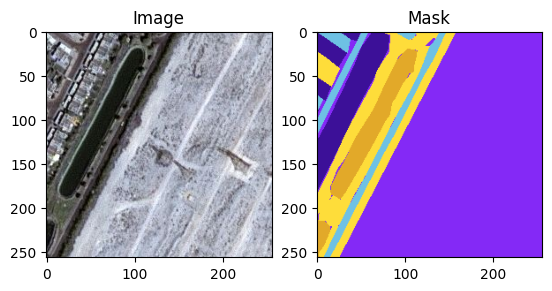

<Figure size 1200x800 with 0 Axes>

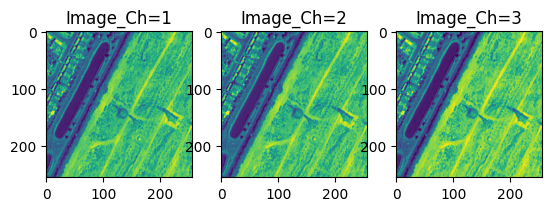

<Figure size 1200x800 with 0 Axes>

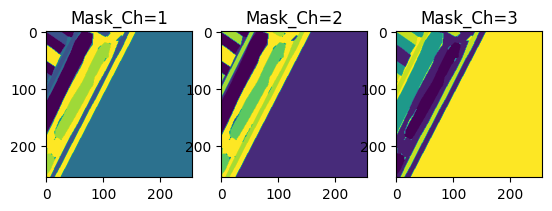

In [10]:
import random

img_num = random.randint(0, img_count - 1)

img_for_plot = cv2.cvtColor(
    cv2.imread(train_img_dir + img_paths[img_num]), 
    cv2.COLOR_BGR2RGB
)

mask_for_plot = cv2.cvtColor(
    cv2.imread(train_msk_dir + msk_paths[img_num]), 
    cv2.COLOR_BGR2RGB
)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, cmap=plt.get_cmap('gray'), vmin=0, vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 3)

axis[0].imshow(img_for_plot[:,:,0])
axis[0].set_title('Image_Ch=1')

axis[1].imshow(img_for_plot[:,:,1])
axis[1].set_title('Image_Ch=2')

axis[2].imshow(img_for_plot[:,:,2])
axis[2].set_title('Image_Ch=3')

# Combine all the operations and display
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 3)

axis[0].imshow(mask_for_plot[:,:,0])
axis[0].set_title("Mask_Ch=1")

axis[1].imshow(mask_for_plot[:,:,1])
axis[1].set_title("Mask_Ch=2")

axis[2].imshow(mask_for_plot[:,:,2])
axis[2].set_title("Mask_Ch=3")

plt.show()


# Этап 2. Предобработка обучающей и валидационной выборки. Разработка архитектуры модели

In [5]:
#Convert HEX to RGB array

Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [6]:
def rgb_to_2D_label(label):
    """
    Преобразовать массив пикселей маски в массив из номеров классов
    """
    if len(label.shape) == 3: 
        label = label[:,:,:3]
    if len(label.shape) == 4: 
        label = label[:,:,:,:3]

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg[np.all(label == Building,axis=-1)] = 0
    label_seg[np.all(label==Land,axis=-1)] = 1
    label_seg[np.all(label==Road,axis=-1)] = 2
    label_seg[np.all(label==Vegetation,axis=-1)] = 3
    label_seg[np.all(label==Water,axis=-1)] = 4
    label_seg[np.all(label==Unlabeled,axis=-1)] = 5

    if len(label.shape) == 3: 
        label_seg = label_seg[:,:,0]
    if len(label.shape) == 4: 
        label_seg = label_seg[:,:,:,0]
        
    return label_seg

In [7]:
scaler = MinMaxScaler()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img) 
    mask = rgb_to_2D_label(mask)
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

In [8]:
seed=24
batch_size= 16
n_classes=6

In [9]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [32]:
train_img_path = r'dataset/train_image/'
train_msk_path = r'dataset/train_mask/'
val_img_path = r'dataset/val_image/'
val_msk_path = r'dataset/val_mask/'

train_img_gen = trainGenerator(train_img_path, train_msk_path, num_class=6)
val_img_gen = trainGenerator(val_img_path, val_msk_path, num_class=6)

num_train_imgs = len(os.listdir(train_img_path + 'train'))
num_val_images = len(os.listdir(val_img_path + 'val'))

steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_images // batch_size

print(f'Train generator steps per epoch: {steps_per_epoch}')
print(f'Validation generator steps per epoch: {val_steps_per_epoch}')

Train generator steps per epoch: 25
Validation generator steps per epoch: 8


Found 411 images belonging to 1 classes.
Found 411 images belonging to 1 classes.


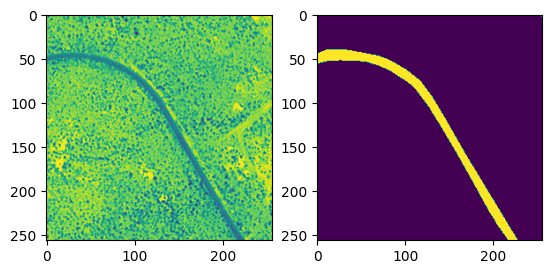

Found 138 images belonging to 1 classes.
Found 138 images belonging to 1 classes.


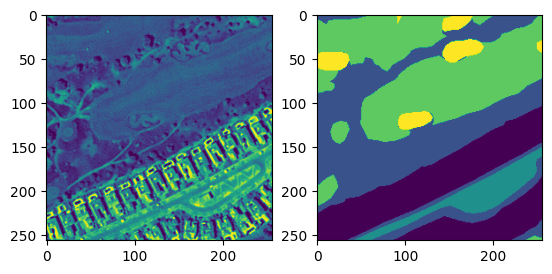

Unique labels in label dataset are:  [0 1 2 3 4]


In [100]:
x, y = train_img_gen.__next__()

for i in range(0,1):
    image = x[i][:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,1):
    image = x_val[i][:,:,0]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

labels, count = np.unique(mask, return_counts=True) #Check for each channel. All chanels are identical

print("Unique labels in label dataset are: ", np.unique(labels))

# Этап 3. Обучение модели

* Изучите техническую документацию по работе с модулем [Segmentation Models](https://segmentation-models.readthedocs.io/en/latest/tutorial.html)

* Последовательно обучите несколько моделей, используя при этом разные [функции потерь ](https://segmentation-models.readthedocs.io/en/latest/api.html#losses)

> [Реализация всех имеющихся в модуле функций потерь на GIT разработчиков](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/losses.py)

* При обучении используйте несколько метрик [метрик](https://segmentation-models.readthedocs.io/en/latest/api.html#metrics), определив их в массиве.



Пример:

```
metrics = ['accuracy', sm.metrics.iou_score]

model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
```
> [Реализация всех имеющихся в модуле метрик на GIT разработчиков](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/metrics.py)



## Модель №1
`categorical_focal_loss`

In [284]:
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_1 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_1.compile(optimizer='adam', loss=sm.losses.categorical_focal_loss, metrics=metrics)
model_1.summary()

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_680 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_680[0][0]         
___________________________________________________________________________________________

In [285]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.callbacks.experimental import BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    #EarlyStopping(monitor='val_accuracy', patience=5, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.001),
    BackupAndRestore(backup_dir),
    CSVLogger("unet_categorical_focal_loss_history.csv", append=True),
    TqdmCallback(verbose=1),
]

history_1 = model_1.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    verbose=0,
    validation_steps=val_steps_per_epoch,
    validation_data=val_img_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [286]:
model_1.save('unet_categorical_focal_loss.h5', save_format="h5")

C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



## Модель №2
`categorical_crossentropy`

In [287]:
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_2 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_2.compile(optimizer='adam', loss=sm.losses.categorical_crossentropy, metrics=metrics)
model_2.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_714 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_714[0][0]         
___________________________________________________________________________________________

In [288]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.callbacks.experimental import BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    #EarlyStopping(monitor='val_accuracy', patience=5, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.001),
    BackupAndRestore(backup_dir),
    CSVLogger("unet_categorical_crossentropy_history.csv", append=True),
    TqdmCallback(verbose=1),
]

history_2 = model_2.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    verbose=0,
    validation_steps=val_steps_per_epoch,
    validation_data=val_img_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [289]:
model_2.save('unet_categorical_crossentropy.h5', save_format="h5")

C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



## Модель №3
`categorical_focal_dice_loss`

In [28]:
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_3 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_3.compile(optimizer='adam', loss=sm.losses.categorical_focal_dice_loss, metrics=metrics)
model_3.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_102 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_102[0][0]         
____________________________________________________________________________________________

In [33]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.callbacks.experimental import BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    #EarlyStopping(monitor='val_accuracy', patience=5, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.001),
    BackupAndRestore(backup_dir),
    CSVLogger("unet_categorical_focal_dice_loss_history.csv", append=True),
    TqdmCallback(verbose=1),
]

history_3 = model_3.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    verbose=0,
    validation_steps=val_steps_per_epoch,
    validation_data=val_img_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Found 411 images belonging to 1 classes.
Found 411 images belonging to 1 classes.


In [35]:
model_3.save('unet_categorical_focal_dice_loss.h5', save_format="h5")

C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



## Модель №4
`categorical_focal_jaccard_loss`

In [20]:
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_4 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_4.compile(optimizer='adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_68 (ZeroPadding2 (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_68[0][0]          
____________________________________________________________________________________________

In [21]:
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.callbacks.experimental import BackupAndRestore

# Создать директорию для бэкапов модели
backup_dir = 'tmp/backup'
Path(backup_dir).mkdir(parents=True, exist_ok=True)

my_callbacks = [
    #EarlyStopping(monitor='val_accuracy', patience=5, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.001),
    BackupAndRestore(backup_dir),
    CSVLogger("unet_categorical_focal_jaccard_loss_history.csv", append=True),
    TqdmCallback(verbose=1),
]

history_4 = model_4.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    verbose=0,
    validation_steps=val_steps_per_epoch,
    validation_data=val_img_gen,
    callbacks=my_callbacks
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [22]:
model_4.save('unet_categorical_focal_jaccard_loss.h5', save_format="h5")

C:\Users\flexl\anaconda3\envs\keras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



# Этап 4. Визуализация процесса обучения. Оценка точности

In [23]:
def print_stats(history_path, name):
    history = pd.read_csv(history_path)
    fig, axs = plt.subplots(4, 1, sharex=True)
    
    fig.set_figwidth(15)
    fig.set_figheight(15)
    fig.suptitle(name)
    plt.xlabel('Epochs', fontsize=10)
    
    axs[0].set_title("Training and validation loss")
    axs[0].plot(history['loss'])
    axs[0].plot(history['val_loss'])
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Training loss', 'Validation loss'], loc="upper right")

    axs[1].set_title("Training and validation accuracy")
    axs[1].plot(history['accuracy'])
    axs[1].plot(history['val_accuracy'])
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Training accuracy', 'Validation accuracy'], loc="lower right")

    axs[2].set_title("Training and validation IOU score")
    axs[2].plot(history['iou_score'])
    axs[2].plot(history['val_iou_score'])
    axs[2].set_ylabel('IOU score')
    axs[2].legend(['Training IOU score', 'Validation IOU score'], loc="lower right")

    axs[3].set_title("Training and validation F1 score")
    axs[3].plot(history['f1-score'])
    axs[3].plot(history['val_f1-score'])
    axs[3].set_ylabel('F1 score')
    axs[3].legend(['Training F1 score', 'Validation F1 score'], loc="lower right")

    fig.subplots_adjust(bottom=0.1, top=0.95)


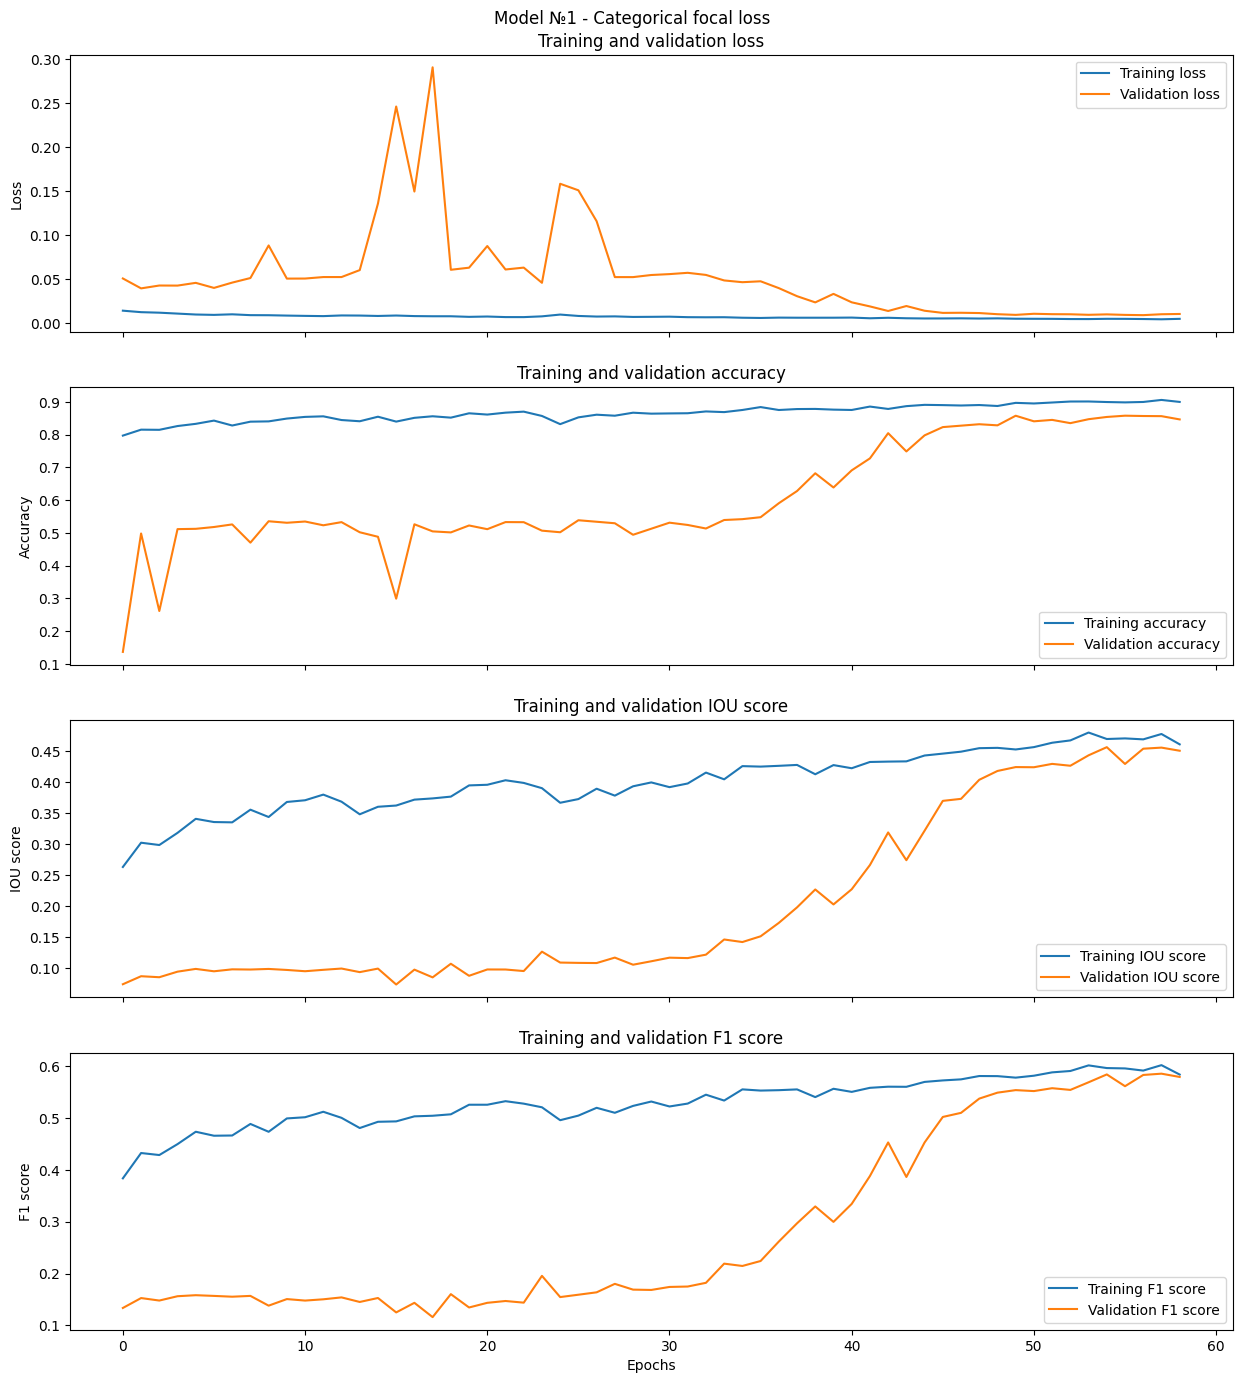

In [24]:
print_stats('unet_categorical_focal_loss_history.csv', 'Model №1 - Categorical focal loss')

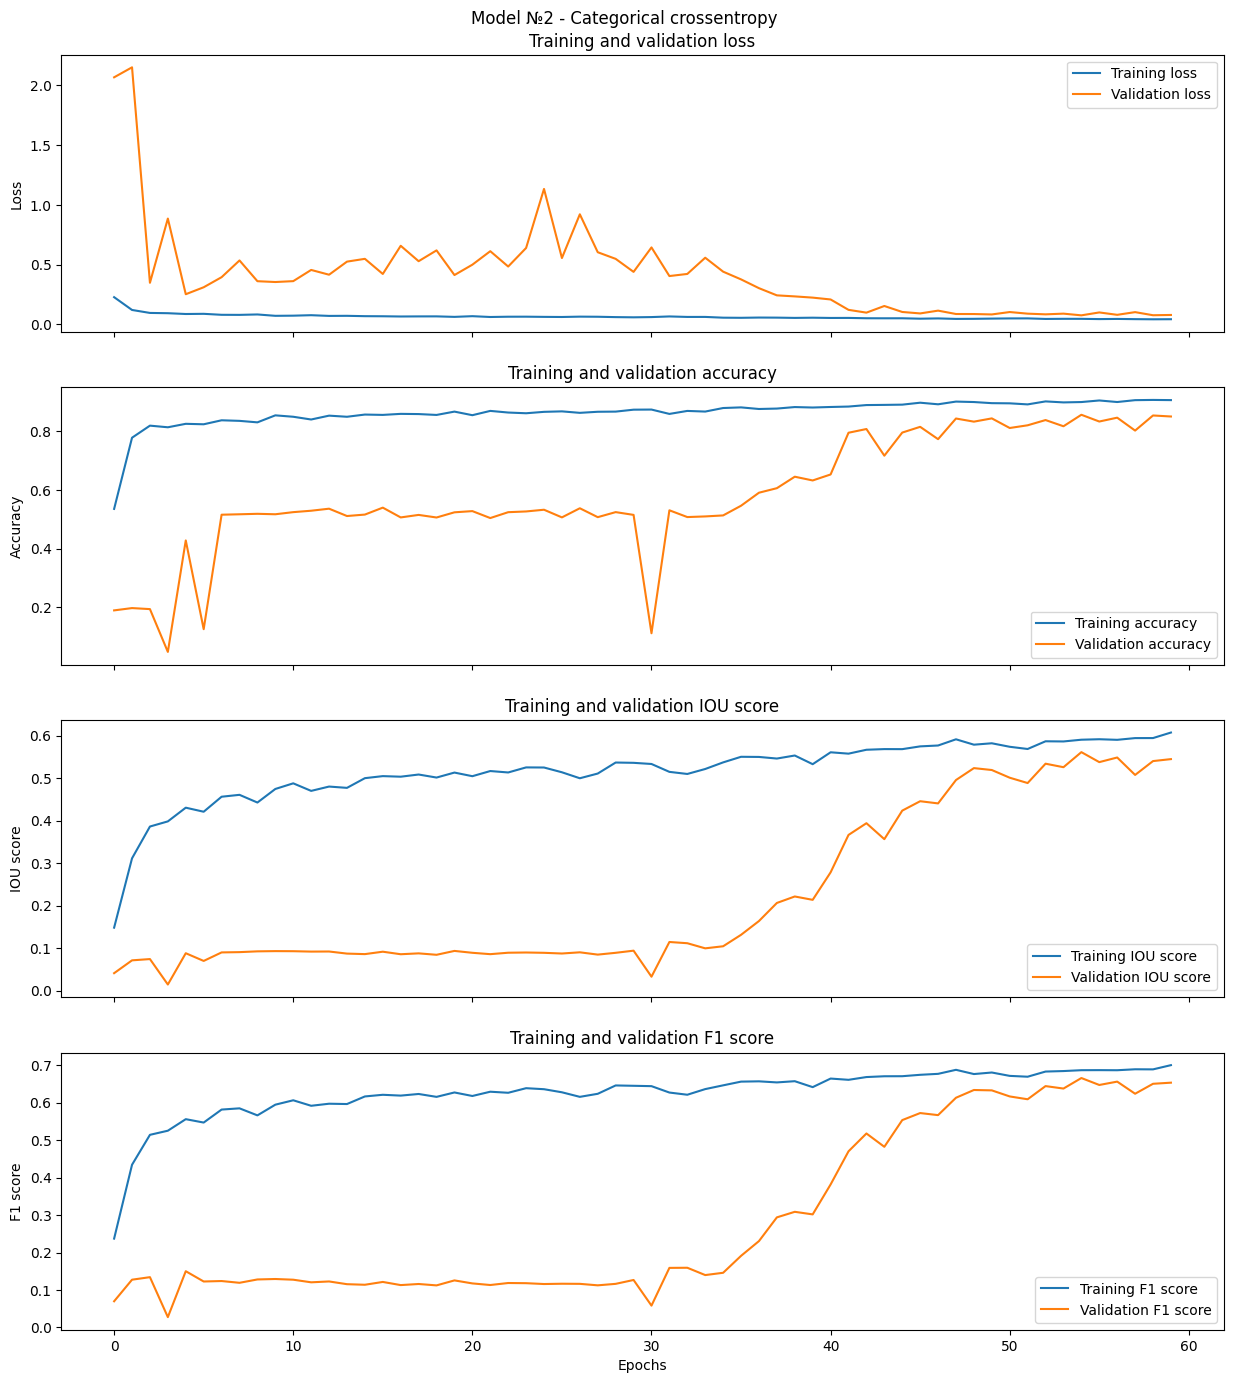

In [25]:
print_stats('unet_categorical_crossentropy_history.csv', 'Model №2 - Categorical crossentropy')

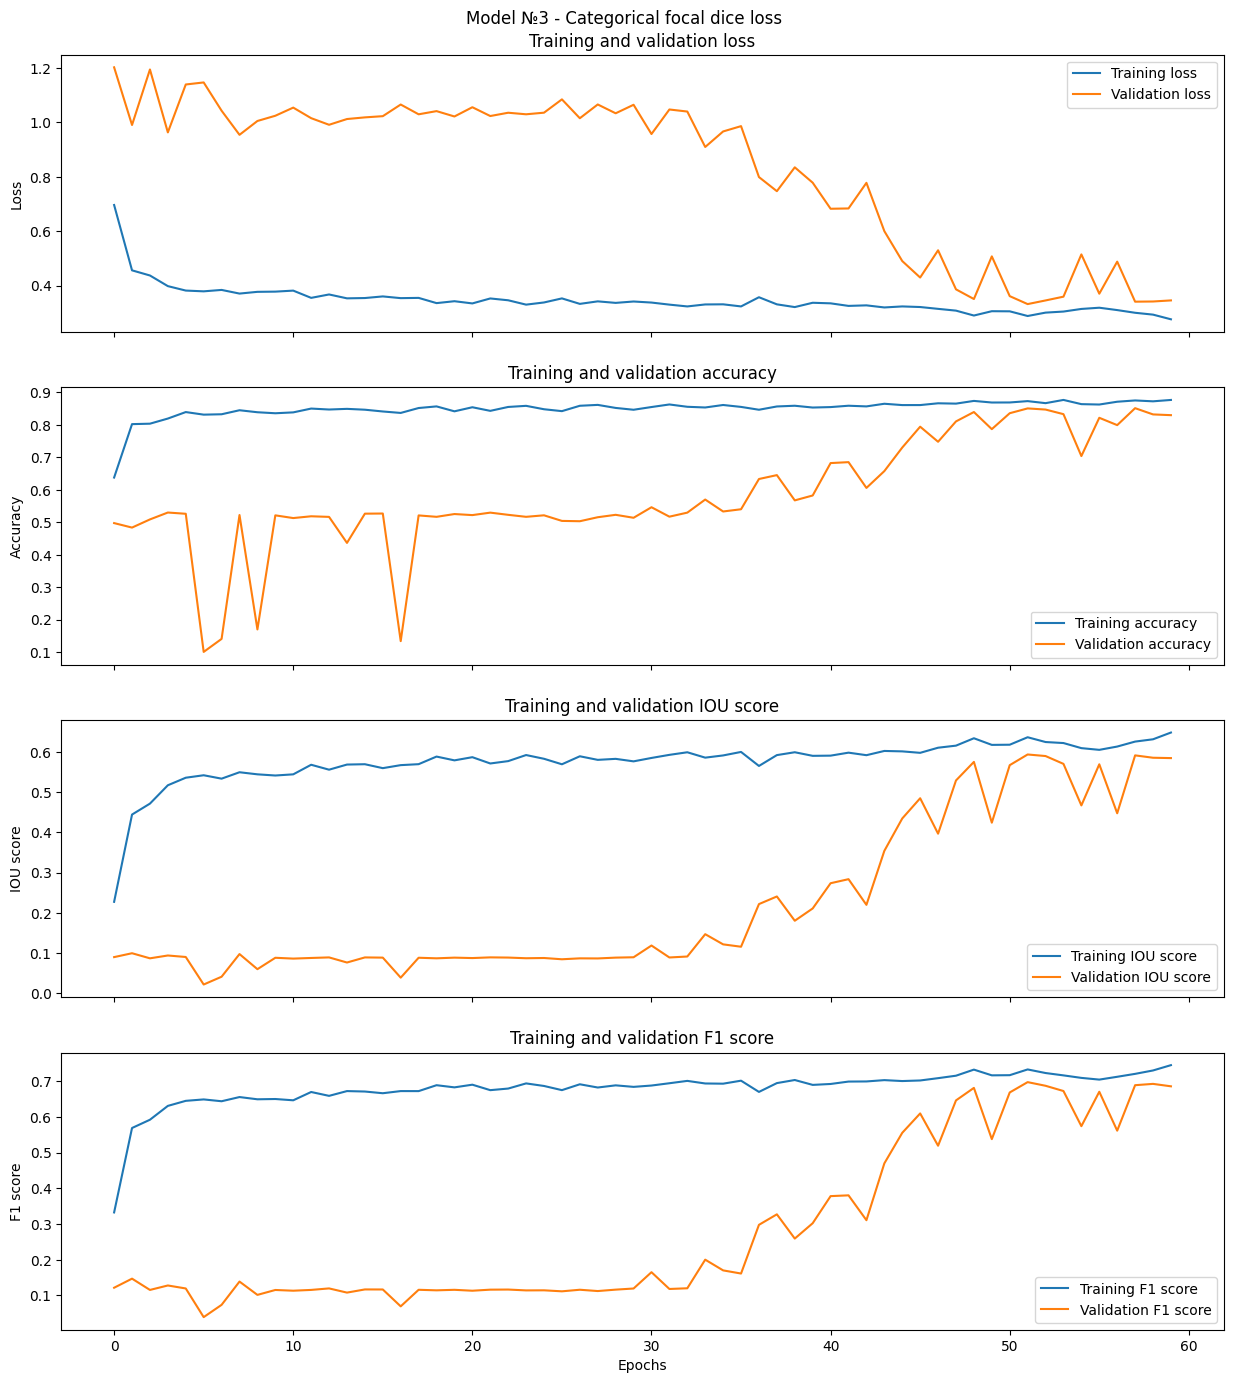

In [34]:
print_stats('unet_categorical_focal_dice_loss_history.csv', 'Model №3 - Categorical focal dice loss')

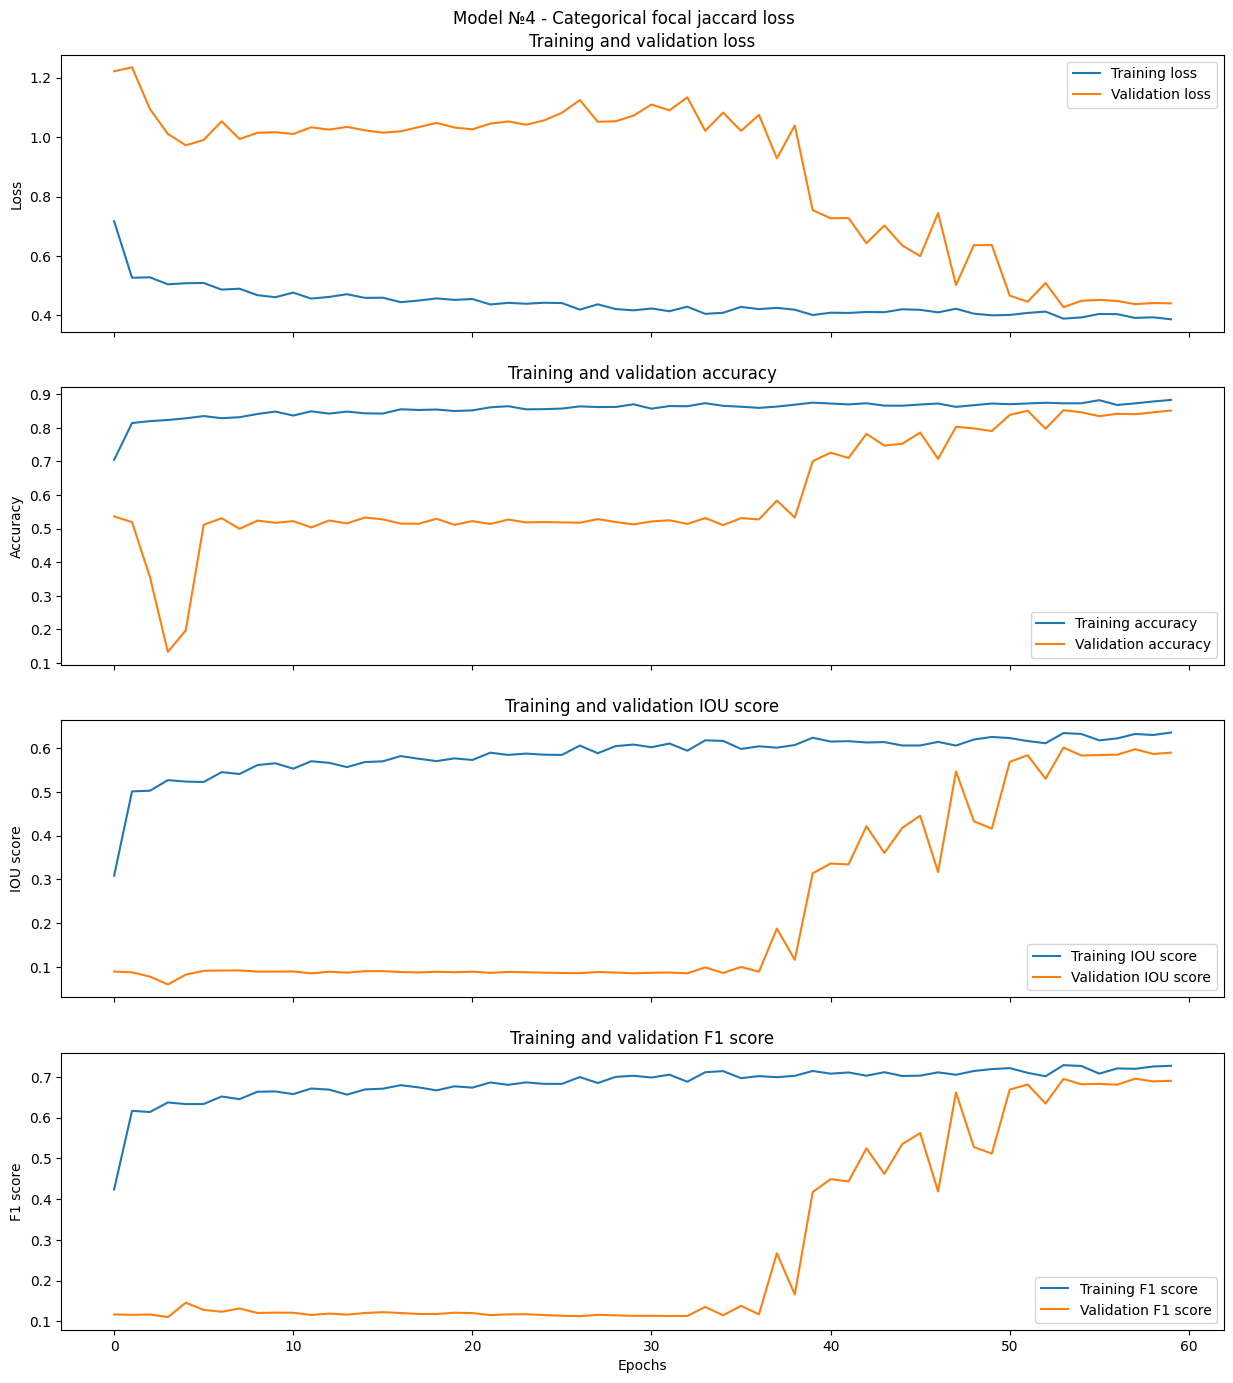

In [27]:
print_stats('unet_categorical_focal_jaccard_loss_history.csv', 'Model №4 - Categorical focal jaccard loss')

Found 138 images belonging to 1 classes.
Found 138 images belonging to 1 classes.


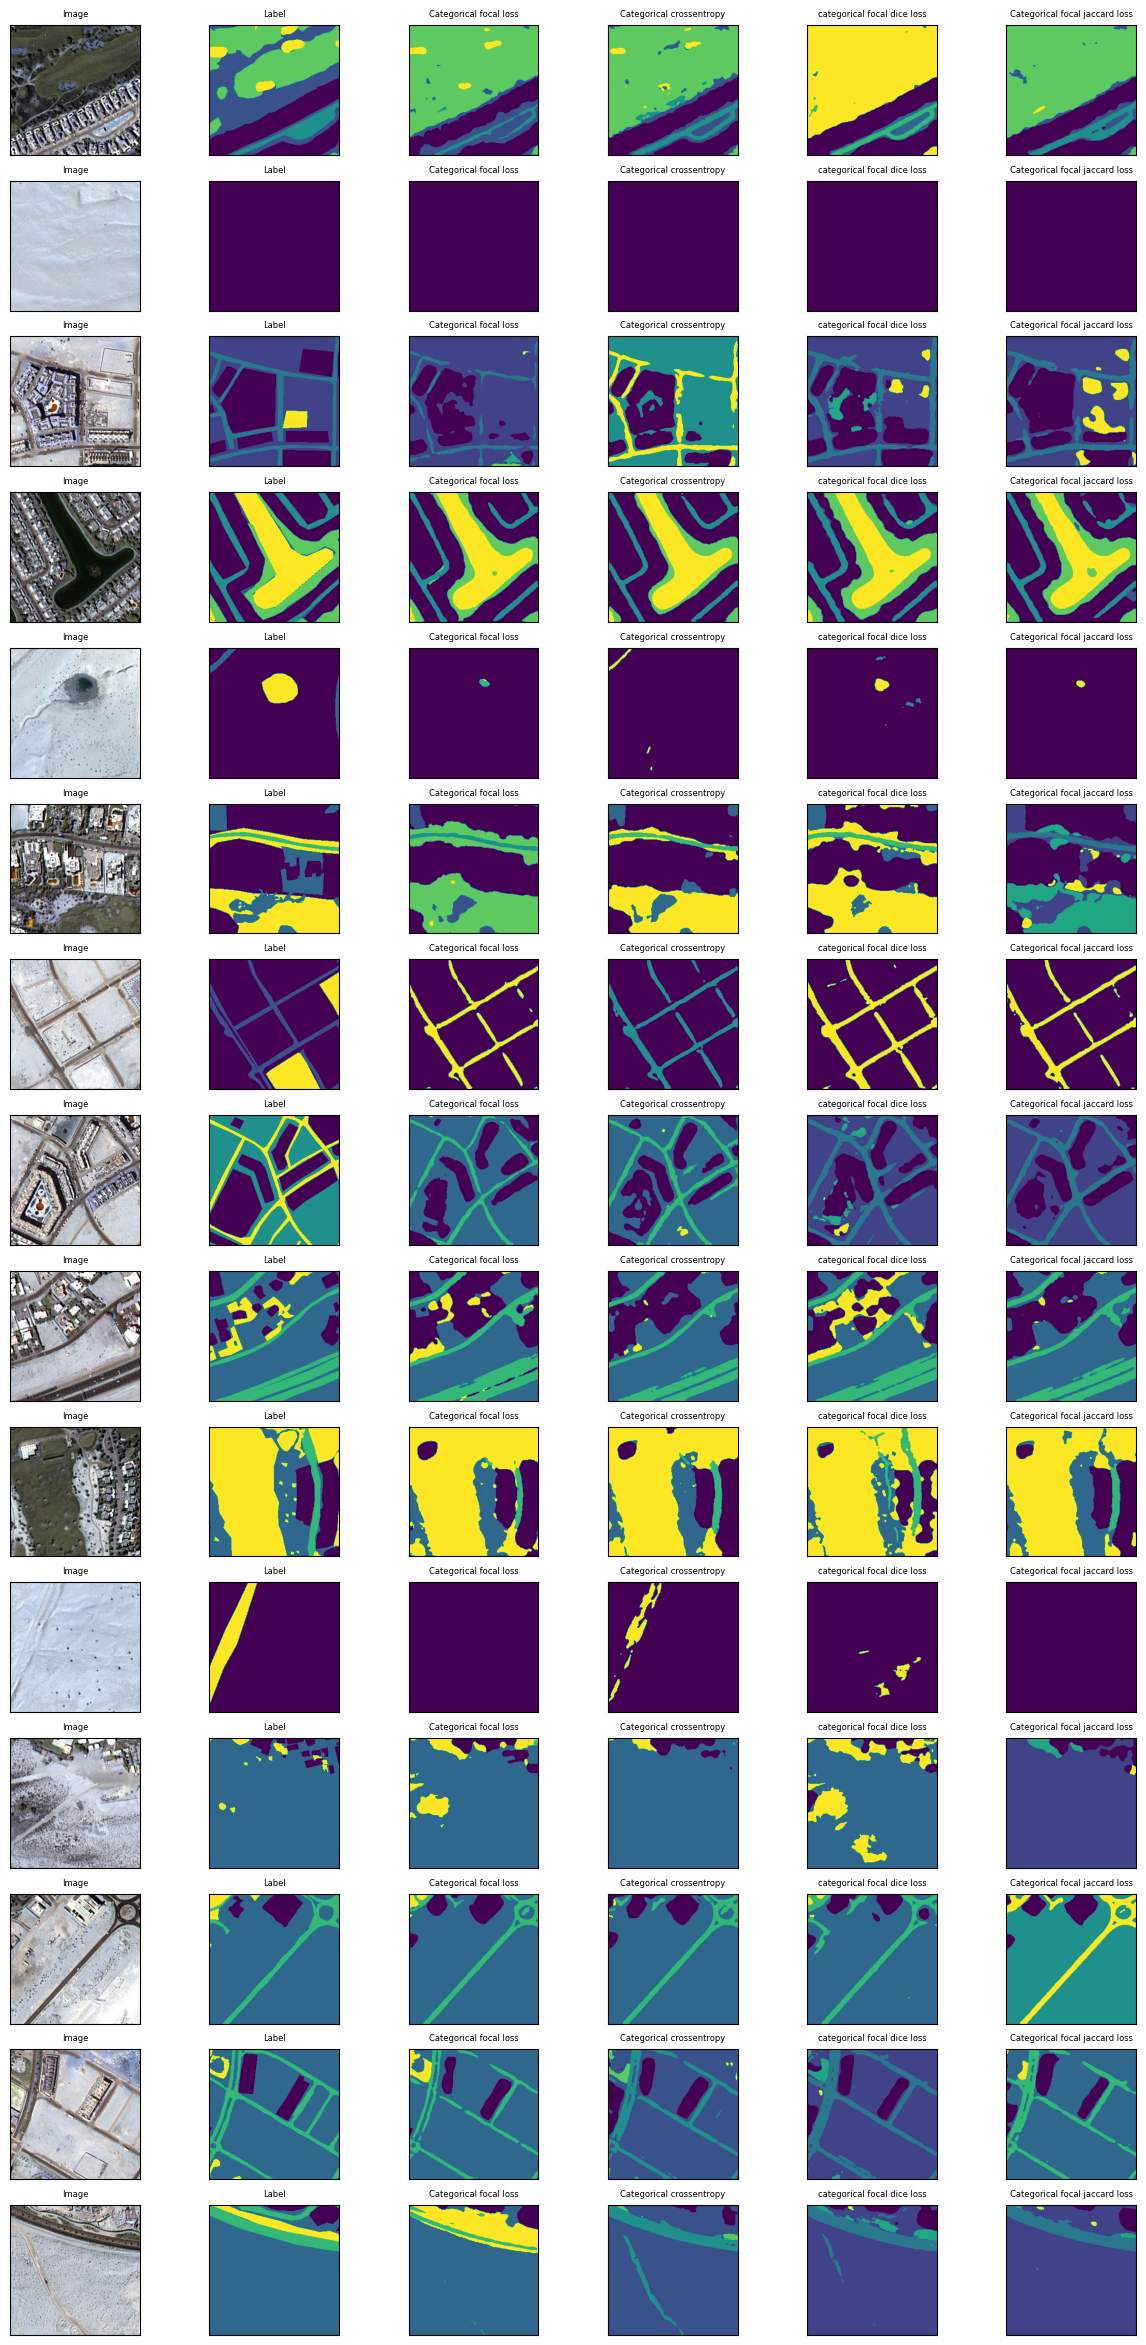

In [36]:
from keras import models

models = [
    models.load_model('unet_categorical_focal_loss.h5', compile=False),
    models.load_model('unet_categorical_crossentropy.h5', compile=False),
    models.load_model('unet_categorical_focal_dice_loss.h5', compile=False),
    models.load_model('unet_categorical_focal_jaccard_loss.h5', compile=False),
]

val_img_gen = trainGenerator(val_img_path, val_msk_path, num_class=6)
image_batch, mask_batch = next(val_img_gen)
mask_batch = np.argmax(mask_batch, axis=3) 

predictions = [np.argmax(model.predict(image_batch), axis=3) for model in models]

image_count = image_batch.shape[0] - 1

# 6 - оригинал + маска + 4 предсказания
fig, axis = plt.subplots(image_count, 6)
fig.set_figwidth(15)
fig.set_figheight(30)

for i in range(image_count):
    axis[i][0].imshow(image_batch[i])
    axis[i][0].set_title('Image', fontsize = 6)
    axis[i][0].axes.xaxis.set_visible(False)
    axis[i][0].axes.yaxis.set_visible(False)

    axis[i][1].imshow(mask_batch[i])
    axis[i][1].set_title("Label", fontsize = 6)
    axis[i][1].axes.xaxis.set_visible(False)
    axis[i][1].axes.yaxis.set_visible(False)

    axis[i][2].imshow(predictions[0][i])
    axis[i][2].set_title("Categorical focal loss", fontsize = 6)
    axis[i][2].axes.xaxis.set_visible(False)
    axis[i][2].axes.yaxis.set_visible(False)

    axis[i][3].imshow(predictions[1][i])
    axis[i][3].set_title("Categorical crossentropy", fontsize = 6)
    axis[i][3].axes.xaxis.set_visible(False)
    axis[i][3].axes.yaxis.set_visible(False)

    axis[i][4].imshow(predictions[2][i])
    axis[i][4].set_title("categorical focal dice loss", fontsize = 6)
    axis[i][4].axes.xaxis.set_visible(False)
    axis[i][4].axes.yaxis.set_visible(False)
    
    axis[i][5].imshow(predictions[3][i])
    axis[i][5].set_title("Categorical focal jaccard loss", fontsize = 6)
    axis[i][5].axes.xaxis.set_visible(False)
    axis[i][5].axes.yaxis.set_visible(False)

plt.show()